<h2> 1. Import the libraries </h2>

In [3]:
import numpy as np
import pandas as pd
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

<h2>2. Read and Explore the Data </h2>

<h3> 2.1 Import the Data and Rename the Columns

In [4]:
# Import the dataset and assign column names
columns=['userId', 'productId', 'ratings','timestamp']
amazon_df=pd.read_csv('ratings_Electronics.csv',names=columns)

In [5]:
#display the first 5 rows of the dataframe
amazon_df.head()

,userId,productId,ratings,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


<h3> 2.2 Drop the timestamp column </h3>

In [6]:
# droping timestamp as the feature is not of much use
amazon_df.drop('timestamp',axis=1,inplace=True)
amazon_df.head()

,userId,productId,ratings
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


<h3> 2.3 Eyeball the raw data </h3>

In [20]:
#Shape of the Dataframe
rows,columns=amazon_df.shape
print('Number of rows: ',rows)
print('Number of columns: ',columns)

Number of rows:  7824482
Number of columns:  3


In [21]:
#Checking for the datatypes
amazon_df.dtypes

userId        object
productId     object
ratings      float64
dtype: object

In [22]:
#checking for blanks
amazon_df.isnull().sum()
#there is no missing data

userId       0
productId    0
ratings      0
dtype: int64

In [23]:
# Concise Summary of the Data
amazon_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 3 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     object 
 1   productId  object 
 2   ratings    float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB


In [24]:
# Summary Statistics (5-point summary) for Rating variable
amazon_df['ratings'].describe().round(2)

count    7824482.00
mean           4.01
std            1.38
min            1.00
25%            3.00
50%            5.00
75%            5.00
max            5.00
Name: ratings, dtype: float64

<h3> 2.4 Exploratory Data Analanysis </h3>

In [25]:
# Number of unique Users and Products in the Dataset, assuming that each userID corresponds to a user.
print('Number of unique Users in Raw data = ', amazon_df['userId'].nunique())
print('Number of unique Product in Raw data = ', amazon_df['productId'].nunique())

Number of unique Users in Raw data =  4201696
Number of unique Product in Raw data =  476002


In [26]:
# Analysis of Users who have used the maximum Products and the Ratings given by them. 
# We will display the top 20 users of products and top 20 products that have been given ratings

#First, let's capture the aggregate of users and mean of product ratings given by each user in the data frame
User_Rate_df = pd.DataFrame(amazon_df.groupby('userId')['ratings'].agg(['mean', 'count']))

In [27]:
# We will sort the values by total products used and mean ratings and display for the top 20 users
User_Rate_df.sort_values(by=['count','mean'],ascending=False).head(20)

,mean,count
userId,,
A5JLAU2ARJ0BO,3.861538,520
ADLVFFE4VBT8,4.283433,501
A3OXHLG6DIBRW8,4.451807,498
A6FIAB28IS79,4.183295,431
A680RUE1FDO8B,4.406404,406
A1ODOGXEYECQQ8,4.305263,380
A36K2N527TXXJN,4.525478,314
A2AY4YUOX2N1BQ,4.559486,311
AWPODHOB4GFWL,4.392857,308


In [28]:
# Analysis of Products that were bought maximum and their Ratings 

#Capture the aggregate of products used and mean of product ratings for each in a data frame
Prod_Rate_df = pd.DataFrame(amazon_df.groupby('productId')['ratings'].agg(['mean', 'count']))


In [29]:
# Sort the rating values by total number of products and mean ratings and display for the top 20 products
Prod_Rate_df.sort_values(by=['count','mean'],ascending=False).head(20)

,mean,count
productId,,
B0074BW614,4.491504,18244
B00DR0PDNE,3.931020,16454
B007WTAJTO,4.424005,14172
B0019EHU8G,4.754497,12285
B006GWO5WK,4.314657,12226
B003ELYQGG,4.392528,11617
B003ES5ZUU,4.704749,10276
B007R5YDYA,4.690926,9907
B00622AG6S,4.420136,9823


In [30]:
# Analysis of Ratings and their total counts
print(amazon_df.ratings.value_counts())

5.0    4347541
4.0    1485781
1.0     901765
3.0     633073
2.0     456322
Name: ratings, dtype: int64


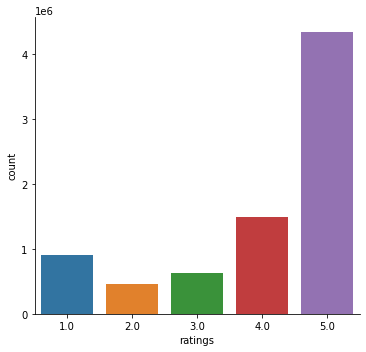

In [31]:
sns.catplot("ratings",data=amazon_df,kind='count')

<h2>3. Take a Subset of the dataset </h2>

In the item-based collaborative filtering framework, the concept of model size revolves around the idea that enough information about a user’s preference lies in a subset of items most similar to items they have already rated highly. It  makes much sense that unseen items that have a high similarity to the highest-rated seen items contribute most towards a final recommender system. Hence we will take a subset of the data to make it less sparse, for instance: we will keep those users who have given 50 or more number of ratings.

In [32]:
# Assigning the counts of unique userId's from the original data set to an Intermediate dataset
data_inter = amazon_df.userId.value_counts()

In [33]:
# Displyaing the first 20 users who have given the maximum number of ratings
data_inter.head(20)

A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
A1ODOGXEYECQQ8    380
A36K2N527TXXJN    314
A2AY4YUOX2N1BQ    311
AWPODHOB4GFWL     308
ARBKYIVNYWK3C     296
A25C2M3QF9G7OQ    296
A22CW0ZHY3NJH8    292
A38RMU1Y5TDP9     282
A3EXWV8FNSSFL6    282
A3LGT6UZL99IW1    279
A2NOW4U7W3F7RI    277
A23GFTVIETX7DS    270
A3PD8JD9L4WEII    266
A17BUUBOU0598B    261
A3AYSYSLHU26U9    257
Name: userId, dtype: int64

In [34]:
# Displaying the total number of users who have given more than 50 ratings
data_inter[data_inter.values>=50].index.shape

(1540,)

In [35]:
#Preparing the final subset of data withusers having more than 50 ratings
data_final=amazon_df[amazon_df['userId'].isin(data_inter[data_inter>=50].index)]

In [36]:
data_final.shape
# Total number of records in the final data set. 

(125871, 3)

5.0    71034
4.0    32295
3.0    12060
2.0     5367
1.0     5115
Name: ratings, dtype: int64


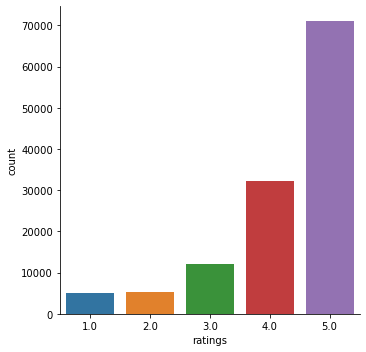

In [37]:
# Analysis of Ratings and their total counts in the final data subset
print(data_final.ratings.value_counts())
sns.catplot("ratings",data=data_final,kind='count')

In [38]:
#Summary statistics of the Final Subset
data_final.describe()

,ratings
count,125871.000000
mean,4.261339
std,1.062144
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


<h3> Final Dataset with a user atleast proving 50 or more ratings </h3>

In [39]:
print(data_final.shape)

(125871, 3)


In [40]:
# Number of unique Users and Products in the Final Subset
print('Number of unique Users in Subset = ', data_final['userId'].nunique())
print('Number of unique Product in Subset = ', data_final['productId'].nunique())

Number of unique Users in Subset =  1540
Number of unique Product in Subset =  48190


<h3> Rating Analysis in the Final Subset </h3>

In [41]:
#Filling products which are not rated zero and taking a pivot to categorize each user with 
# the product they rated
final_ratings_matrix = pd.pivot_table(data_final,index='userId',columns='productId',values = 'ratings').fillna(0)

In [29]:
#Checking the density of rated products. User provided ratings to very less products or we can also say they did not buy 
#those products
given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

given_num_of_ratings =  125871
possible_num_of_ratings =  74212600
density: 0.17%


In [30]:
# Matrix with one row per 'Product' and one column per 'user' for Item-based CF
final_ratings_matrix_T = final_ratings_matrix.transpose()
final_ratings_matrix_T.head()

userId,A100UD67AHFODS,A100WO06OQR8BQ,A105S56ODHGJEK,A105TOJ6LTVMBG,A10AFVU66A79Y1,A10H24TDLK2VDP,A10NMELR4KX0J6,A10O7THJ2O20AG,A10PEXB6XAQ5XF,A10X9ME6R66JDX,...,AYOTEJ617O60K,AYP0YPLSP9ISM,AZ515FFZ7I2P7,AZ8XSDMIX04VJ,AZAC8O310IK4E,AZBXKUH4AIW3X,AZCE11PSTCH1L,AZMY6E8B52L2T,AZNUHQSHZHSUE,AZOK5STV85FBJ
productId,,,,,,,,,,,,,,,,,,,,,
0594451647,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0594481813,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0970407998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0972683275,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1400501466,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<h2>4. Splitting the data </h2>

In [31]:
from sklearn.model_selection import train_test_split
#Split the data randomnly into test and train datasets
#Split the training and test data in the ratio 70:30
train_data, test_data = train_test_split(data_final, test_size = 0.3, random_state=10)
train_data.head()

,userId,productId,ratings
7760154,A2JKM8KF3296CW,B00HPM1G8Q,5.0
4898726,A2MSBIA18RXYQC,B005F5II1I,2.0
2725558,AGYH5U11ZKPFB,B002MZUNXU,5.0
3600596,A6FIAB28IS79,B003VAHYXW,4.0
3084188,A3IJ4Z18FTIIP,B00365EVXI,1.0


In [32]:
# Train and Test data shape
print(train_data.shape)
print(test_data.shape)

(88109, 3)
(37762, 3)


<h2>5. Popularity Recommender Model </h2>

In [33]:
#Count of user_id for each unique product as recommendation score 
train_data_grouped = train_data.groupby('productId').agg({'userId': 'count'}).reset_index()
train_data_grouped.rename(columns = {'userId': 'score'},inplace=True)
train_data_grouped.head(20)

,productId,score
0,0594451647,1
1,0970407998,2
2,0972683275,3
3,1400501466,4
4,1400501520,1
5,1400501776,2
6,1400532620,1
7,1400532655,6
8,140053271X,2
9,1400599997,2


In [34]:
#Sort the products on recommendation score 
train_data_sort = train_data_grouped.sort_values(['score', 'productId'], ascending = [0,1]) 
      
#Generate a recommendation rank based upon score 
train_data_sort['rank'] = train_data_sort['score'].rank(ascending=0, method='first') 
          
#Get the top 5 recommendations 
popularity_recommendations = train_data_sort.head(5) 
popularity_recommendations 

,productId,score,rank
30874,B0088CJT4U,142,1.0
19570,B003ES5ZUU,134,2.0
30273,B007WTAJTO,126,3.0
8700,B000N99BBC,117,4.0
30561,B00829TIEK,104,5.0


In [35]:
# Use popularity based recommender model to make predictions
def recommend(user_id):     
    user_recommendations = popularity_recommendations 
          
    #Add user_id column for which the recommendations are being generated 
    user_recommendations['userId'] = user_id 
      
    #Bring user_id column to the front 
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations 

In [36]:
find_recom = [1267,385,40]   # This list is user choice.
for i in find_recom:
    print("Here is the recommendation for the userId: ", i)
    print("The products are most sold along with there mean rating:\n")
    print(recommend(i))    
    print("\n") 

Here is the recommendation for the userId:  1267
The products are most sold along with there mean rating:

       userId   productId  score  rank
30874    1267  B0088CJT4U    142   1.0
19570    1267  B003ES5ZUU    134   2.0
30273    1267  B007WTAJTO    126   3.0
8700     1267  B000N99BBC    117   4.0
30561    1267  B00829TIEK    104   5.0


Here is the recommendation for the userId:  385
The products are most sold along with there mean rating:

       userId   productId  score  rank
30874     385  B0088CJT4U    142   1.0
19570     385  B003ES5ZUU    134   2.0
30273     385  B007WTAJTO    126   3.0
8700      385  B000N99BBC    117   4.0
30561     385  B00829TIEK    104   5.0


Here is the recommendation for the userId:  40
The products are most sold along with there mean rating:

       userId   productId  score  rank
30874      40  B0088CJT4U    142   1.0
19570      40  B003ES5ZUU    134   2.0
30273      40  B007WTAJTO    126   3.0
8700       40  B000N99BBC    117   4.0
30561      40  

<h4> Since, it is a Popularity recommender model, so, all the three users are given the same recommendations. Here, we predict the products based on the popularity. It is not personalized to particular user. It is a non-personalized recommender system. </h4>

<h2>6. Collabortive Filtering Model </h2>

In [37]:
amazon_df_CF = pd.concat([train_data, test_data]).reset_index()
amazon_df_CF.head()

,index,userId,productId,ratings
0,7760154,A2JKM8KF3296CW,B00HPM1G8Q,5.0
1,4898726,A2MSBIA18RXYQC,B005F5II1I,2.0
2,2725558,AGYH5U11ZKPFB,B002MZUNXU,5.0
3,3600596,A6FIAB28IS79,B003VAHYXW,4.0
4,3084188,A3IJ4Z18FTIIP,B00365EVXI,1.0


In [38]:
# Matrix with row per 'user' and column per 'item' 
pivot_df = amazon_df_CF.pivot(index = 'userId', columns ='productId', values = 'ratings').fillna(0)
pivot_df.head()

productId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
userId,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
print('Shape of the pivot table: ', pivot_df.shape)

Shape of the pivot table:  (1540, 48190)


In [40]:
#define user index from 0 to 10
pivot_df['user_index'] = np.arange(0, pivot_df.shape[0], 1)
pivot_df.head()

productId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8,user_index
userId,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [41]:
pivot_df.set_index(['user_index'], inplace=True)
# Actual ratings given by users
pivot_df.head()

productId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


***As this is a sparse matrix we will use SVD.

<h3> Singular Value Decomposition </h3>

In [42]:
# Singular Value Decomposition
U, sigma, Vt = svds(pivot_df, k = 10)

In [43]:
print('Left singular matrix: \n',U)

Left singular matrix: 
 [[ 0.00899214  0.00598943 -0.01133778 ... -0.02098223 -0.03450332
  -0.02112691]
 [ 0.0078874   0.01984352 -0.00397075 ... -0.01076097  0.02009915
  -0.03863719]
 [ 0.00060497 -0.00421198 -0.00381018 ...  0.02924332  0.03319807
  -0.03354122]
 ...
 [-0.0069631   0.0863053   0.02353607 ... -0.01332978 -0.1613707
  -0.05949368]
 [-0.00238725  0.0032176  -0.00374118 ... -0.00677598  0.00445708
  -0.01348483]
 [-0.00097386  0.00410379  0.002161   ... -0.01215862 -0.00249329
  -0.00561029]]


In [44]:
print('Sigma: \n',sigma)

Sigma: 
 [ 87.43474122  88.68897677  91.15027972  92.15989229  95.03789667
  98.21626326 100.38232831 107.7090351  119.69501814 182.29276718]


*** As sigma is not a diagonal matrix we have to convert it into diagonal matrix.

In [45]:
# Construct diagonal array in SVD
sigma = np.diag(sigma)
print('Diagonal matrix: \n',sigma)

Diagonal matrix: 
 [[ 87.43474122   0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.          88.68897677   0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.          91.15027972   0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.          92.15989229   0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.          95.03789667
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
   98.21626326   0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.         100.38232831   0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.           0.      

In [46]:
print('Right singular matrix: \n',Vt)

Right singular matrix: 
 [[-2.31966546e-04 -4.68044406e-04 -1.43854010e-04 ...  2.30584720e-02
   8.19034231e-03  1.83182807e-03]
 [-1.20917225e-04 -5.52580088e-04  3.34185097e-04 ... -2.44735821e-02
  -4.79762018e-04 -1.00226998e-03]
 [ 2.66495818e-04  1.86012492e-04 -4.76652015e-04 ...  9.93151909e-03
   2.54217806e-03 -4.78476864e-04]
 ...
 [-8.81590303e-04 -1.31370545e-03 -4.21874643e-04 ...  1.37986535e-02
   4.52761832e-03 -1.09691626e-03]
 [-4.58579287e-05 -1.88881713e-04 -9.00497985e-05 ... -3.32629345e-02
  -1.31262740e-02 -2.24988359e-03]
 [-2.02226218e-04 -2.59177123e-04 -6.62049181e-04 ... -1.02695130e-02
  -3.76431121e-03 -8.69030592e-04]]


In [47]:
#Predicted ratings
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
# Convert predicted ratings to dataframe
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = pivot_df.columns)
preds_df.head()

productId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
0,0.002661,0.003576,0.004050,0.006906,0.003967,0.003073,0.005782,0.000568,0.014386,0.002708,...,6.108890e-04,0.044224,0.002919,0.060347,-0.002137,0.006751,0.001525,0.130951,0.059243,0.015014
1,0.002262,0.002505,0.005136,0.016517,0.007120,0.001438,0.013258,0.000335,-0.003781,0.001190,...,2.024793e-04,0.029213,0.000010,0.000244,-0.003111,-0.000621,0.004409,-0.039241,-0.006889,0.003696
2,-0.001600,-0.002502,0.002186,0.016742,0.006716,-0.002113,0.005805,0.003497,-0.005009,-0.001588,...,-3.240446e-04,0.009180,-0.002459,-0.016922,0.019936,-0.002483,-0.000155,-0.002889,-0.011522,-0.004525
3,0.002732,0.003867,0.001799,0.009395,0.004075,0.002778,0.003507,0.000095,0.007983,0.002381,...,6.031462e-04,-0.003369,0.003433,-0.003428,-0.000750,0.000119,0.002612,-0.015107,-0.006740,0.003276
4,0.000704,0.000085,0.002051,0.009664,0.004438,0.000335,0.005992,0.001056,-0.000369,0.000373,...,3.745108e-08,-0.001140,-0.000323,-0.025215,0.004700,-0.002170,0.001263,-0.048555,-0.016301,-0.003377


In [48]:
# Recommend the items with the highest predicted ratings

def recommend_items(userID, pivot_df, preds_df, num_recommendations):
    # index starts at 0  
    user_idx = userID-1 
    # Get and sort the user's ratings
    sorted_user_ratings = pivot_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_ratings
    sorted_user_predictions = preds_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_predictions
    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']
    temp = temp.loc[temp.user_ratings == 0]   
    temp = temp.sort_values('user_predictions', ascending=False)
    print('\nBelow are the recommended items for user(user_id = {}):\n'.format(userID))
    print(temp.head(num_recommendations))

In [49]:
userID = 4
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)    


Below are the recommended items for user(user_id = 4):

                   user_ratings  user_predictions
Recommended Items                                
B007WTAJTO                  0.0          0.824345
B003ES5ZUU                  0.0          0.664491
B002V88HFE                  0.0          0.430415
B001TH7GUU                  0.0          0.387479
B005FYNSPK                  0.0          0.360464


In [50]:
userID = 6
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 6):

                   user_ratings  user_predictions
Recommended Items                                
B00829TIEK                  0.0          1.354348
B008DWCRQW                  0.0          1.194768
B004CLYEDC                  0.0          1.021913
B002R5AM7C                  0.0          0.934417
B00829THK0                  0.0          0.926751


In [51]:
userID = 8
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 8):

                   user_ratings  user_predictions
Recommended Items                                
B003ES5ZUU                  0.0          1.919363
B002V88HFE                  0.0          1.430753
B002WE6D44                  0.0          1.258002
B001TH7GUU                  0.0          1.249597
B005HMKKH4                  0.0          0.976093


* Since, it is a Collaborative recommender model, so, all the three users are given different recommendations based on users past behaviour.

<h2> 7. Evaluation of Recommendation models </h2> 

In [52]:
# Actual ratings given by the users
final_ratings_matrix.head()

productId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
userId,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
# Average ACTUAL rating for each item
final_ratings_matrix.mean().head()

productId
0594451647    0.003247
0594481813    0.001948
0970407998    0.003247
0972683275    0.012338
1400501466    0.012987
dtype: float64

In [54]:
# Predicted ratings 
preds_df.head()

productId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
0,0.002661,0.003576,0.004050,0.006906,0.003967,0.003073,0.005782,0.000568,0.014386,0.002708,...,6.108890e-04,0.044224,0.002919,0.060347,-0.002137,0.006751,0.001525,0.130951,0.059243,0.015014
1,0.002262,0.002505,0.005136,0.016517,0.007120,0.001438,0.013258,0.000335,-0.003781,0.001190,...,2.024793e-04,0.029213,0.000010,0.000244,-0.003111,-0.000621,0.004409,-0.039241,-0.006889,0.003696
2,-0.001600,-0.002502,0.002186,0.016742,0.006716,-0.002113,0.005805,0.003497,-0.005009,-0.001588,...,-3.240446e-04,0.009180,-0.002459,-0.016922,0.019936,-0.002483,-0.000155,-0.002889,-0.011522,-0.004525
3,0.002732,0.003867,0.001799,0.009395,0.004075,0.002778,0.003507,0.000095,0.007983,0.002381,...,6.031462e-04,-0.003369,0.003433,-0.003428,-0.000750,0.000119,0.002612,-0.015107,-0.006740,0.003276
4,0.000704,0.000085,0.002051,0.009664,0.004438,0.000335,0.005992,0.001056,-0.000369,0.000373,...,3.745108e-08,-0.001140,-0.000323,-0.025215,0.004700,-0.002170,0.001263,-0.048555,-0.016301,-0.003377


In [55]:
# Average PREDICTED rating for each item
preds_df.mean().head()

productId
0594451647    0.001542
0594481813    0.002341
0970407998    0.002597
0972683275    0.011807
1400501466    0.004848
dtype: float64

In [56]:
rmse_df = pd.concat([final_ratings_matrix.mean(), preds_df.mean()], axis=1)
rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
print(rmse_df.shape)
rmse_df['item_index'] = np.arange(0, rmse_df.shape[0], 1)
rmse_df.head()

(48190, 2)


,Avg_actual_ratings,Avg_predicted_ratings,item_index
productId,,,
0594451647,0.003247,0.001542,0
0594481813,0.001948,0.002341,1
0970407998,0.003247,0.002597,2
0972683275,0.012338,0.011807,3
1400501466,0.012987,0.004848,4


In [57]:
RMSE = round((((rmse_df.Avg_actual_ratings - rmse_df.Avg_predicted_ratings) ** 2).mean() ** 0.5), 5)
print('\nRMSE SVD Model = {} \n'.format(RMSE))


RMSE SVD Model = 0.0033 



<h2> 8. Get top - K ( K = 5) recommendations.  </h2>
Since our goal is to recommend new products to each user based on his/her habits, we will 
recommend 5 new products.

In [58]:
# Singular Value Decomposition
U, sigma, Vt = svds(final_ratings_matrix, k = 10)
# Construct diagonal array in SVD
sigma = np.diag(sigma)

In [59]:
predicted_ratings = np.dot(np.dot(U, sigma), Vt) 

# Predicted ratings
preds_df = pd.DataFrame(predicted_ratings, columns = final_ratings_matrix.columns)

In [60]:
# Enter 'userID' and 'num_recommendations' for the user #
userID = 1267
num_recommendations = 5
recommend_items(userID, final_ratings_matrix, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 1267):

                   user_ratings  user_predictions
Recommended Items                                
B0088CJT4U                  0.0          1.086446
B000N99BBC                  0.0          0.911772
B00829TIEK                  0.0          0.800758
B00829THK0                  0.0          0.705223
B002R5AM7C                  0.0          0.675636


In [61]:
userID = 385
num_recommendations = 5
recommend_items(userID, final_ratings_matrix, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 385):

                   user_ratings  user_predictions
Recommended Items                                
B003ES5ZUU                  0.0          0.586356
B007WTAJTO                  0.0          0.508863
B002V88HFE                  0.0          0.345909
B001TH7GUU                  0.0          0.291679
B000QUUFRW                  0.0          0.253369


In [62]:
userID = 40
num_recommendations = 5
recommend_items(userID, final_ratings_matrix, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 40):

                   user_ratings  user_predictions
Recommended Items                                
B003ES5ZUU                  0.0          0.562864
B007WTAJTO                  0.0          0.521629
B002V88HFE                  0.0          0.354552
B001TH7GUU                  0.0          0.291192
B000QUUFRW                  0.0          0.260331


<h2> 9. Summarising insights. </h2>


* The Popularity-based recommender system is a non-personalised recommender system and these are based on frequecy counts, which may be not suitable to the user.We can see the differance above for the user id 4, 6 & 8, The Popularity based model has recommended the same set of 5 products to both but Collaborative Filtering based model has recommended entire different list based on the user past purchase history.

* Model-based Collaborative Filtering is a personalised recommender system, the recommendations are based on the past behavior of the user and it is not dependent on any additional information.